# Jessica's Charts

In [1]:
# !pip install altair_saver --quiet

## Loading dependencies/libraries

In [2]:
import sys
import os
import altair as alt
import pandas as pd
from toolz.curried import pipe
from altair_saver import save

# # Create a new data transformer that stores the files in a directory
def json_dir(data, data_dir='altairdata'):
    os.makedirs(data_dir, exist_ok=True)
    return pipe(data, alt.to_json(filename=data_dir + '/{prefix}-{hash}.{extension}') )

# # Register and enable the new transformer
alt.data_transformers.register('json_dir', json_dir)
alt.data_transformers.enable('json_dir')

sys.path.append('..')
from scripts import wrangle_and_clean as wac

# Handle large data sets (default shows only 5000)
# See here: https://altair-viz.github.io/user_guide/data_transformers.html
alt.data_transformers.disable_max_rows()

alt.renderers.enable('jupyterlab')

RendererRegistry.enable('jupyterlab')

## Load & Wrangle Data

In [3]:
mxmh = wac.clean_data("../data/raw/mxmh_survey_results.csv")
mxmh.head()

,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,...,Frequency_K_pop_numeric,Frequency_Latin_numeric,Frequency_Lofi_numeric,Frequency_Metal_numeric,Frequency_Pop_numeric,Frequency_R&B_numeric,Frequency_Rap_numeric,Frequency_Rock_numeric,Frequency_Video_game_music_numeric,Genre Diversity Score
0,2022-08-27 19:29:02,18.0,Spotify,3.0,Yes,Yes,Yes,Latin,Yes,Yes,...,3,3,1,0,3,2,3,0,2,10
1,2022-08-27 19:57:31,63.0,Pandora,1.5,Yes,No,No,Rock,Yes,No,...,1,2,1,0,2,2,1,3,1,13
2,2022-08-27 21:28:18,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,...,3,0,2,2,1,0,1,1,3,10
3,2022-08-27 21:40:40,61.0,YouTube Music,2.5,Yes,No,Yes,Jazz,Yes,Yes,...,2,3,2,0,2,2,0,0,0,9
4,2022-08-27 21:54:47,18.0,Spotify,4.0,Yes,No,No,R&B,Yes,No,...,3,2,2,0,2,3,3,0,1,10


In [4]:
mxmh_scores = mxmh.melt(id_vars=["Timestamp", "Age", "Music effects"], 
                     value_vars=["Anxiety", "Depression", "Insomnia", "OCD"], 
                     var_name="Mental Health Condition", 
                     value_name="Self-report Score")

music_effects_ordered = ['Improve', 'No effect', 'Worsen', 'No response']

mxmh_scores["Music effects"] = pd.Categorical(mxmh_scores["Music effects"], 
                                              categories=music_effects_ordered, 
                                              ordered=True)

music_effects_map = {"Improve": 1, "No effect": 2, "Worsen": 3, "No response":4}
mxmh_scores["Music effects (ordered)"] = mxmh_scores["Music effects"].map(music_effects_map)

## Aesthetic Settings

In [5]:
# === COLOR PALETTE === #
okabe_ito_palette = [
    "#009E73",  # Green
    "#0072B2",  # Blue
    "#56B4E9",  # Sky Blue
    "#F0E442",  # Yellow
    "#E69F00",  # Orange
    "#D55E00",  # Vermillion
    "#CC79A7",  # Pink
    '#23338A',  # Dark Blue [colour blind safe addition]
]

### === Color and Order for Music Effects === ###
music_effects_ordered = ['Improve', 'No effect', 'Worsen', 'No response']
# music_effects_ordered = ['1', '2', '3', '4']
# effect_colors = ["mediumaquamarine", "khaki", "orange", "grey"]
effect_colors = ["#009E73", "#F0E442", "#E69F00", "grey"]
effect_color_scale = alt.Scale(domain=music_effects_ordered, range=effect_colors)

### === Color and Order for Mental Health === ###
mental_health_ordered = ['Anxiety', 'Depression', 'Insomnia', 'OCD']
health_colors = ["#009E73", "#23338A", "#E69F00", "#F0E442"]
health_color_scale = alt.Scale(domain=mental_health_ordered, range=health_colors)

In [6]:
# === FONT SETTING ===
font_choice = "Segoe UI"

legend_configuration = {"titleFontSize": 15,
    "labelFontSize": 15,
    "fillColor": '#F5F5F5',
    "padding": 10,
    "cornerRadius": 10,
    "labelFont": font_choice,
    "labelSeparation": 5,
    "titleFont": font_choice,
    "titleLimit": 240
}

title_configuration = {
    "fontSize": 25,
    "anchor": "middle", 
    "font": font_choice,
    "subtitlePadding": 10,
    "subtitleFont": font_choice,
    "subtitleColor": "grey10",
    "subtitleFontSize": 17
}

axis_configuration = {
    "labelFont": font_choice,
    "titleFont": font_choice,
    "labelFontSize": 15,
    "titleFontSize": 18
}

header_configuration = {
    "labelFont": font_choice,
    "titleFont": font_choice,
    "labelFontSize": 15,
    "titleFontSize": 18
}

## Question 1: What is the distribution of self-reported mental health scores based on opinions of music on mental health?

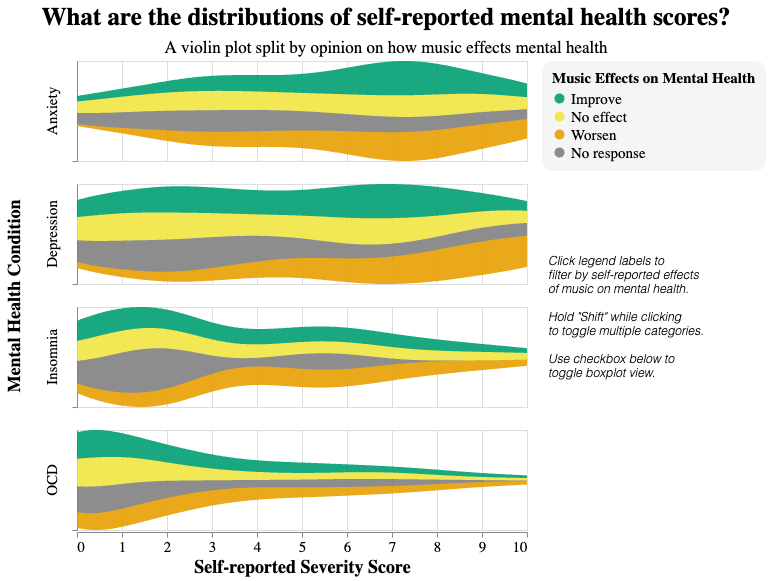

In [7]:
### WIDGETS ###
selection = alt.selection_point(fields=["Music effects"], bind="legend", empty=True)

bind_checkbox = alt.binding_checkbox(name="Show Boxplot: ")
param_checkbox = alt.param(bind=bind_checkbox)

### BOX PLOT ###
boxplot = (
    alt.Chart(mxmh_scores)
    .mark_boxplot(color="black", opacity=0.4, size=30)
    .encode(
        alt.X("Self-report Score:Q", title="Self-reported Severity Score"),
        opacity=alt.when(param_checkbox).then(alt.value(0.7)).otherwise(alt.value(0)),
    )
    .add_params(param_checkbox)
    .properties(width=450)
)

### VIOLIN PLOT ###
violin = (
    alt.Chart(mxmh_scores)
    .transform_density(
        "Self-report Score",
        as_=["Self-report Score", "density"],
        extent=[0, 10],
        groupby=["Mental Health Condition:N", "Music effects"],
    )
    .mark_area(opacity=0.9, orient="vertical", interpolate="monotone", tooltip=True)
    .encode(
        x=alt.X("Self-report Score:Q", title="Self-reported Severity Score"),
        y=alt.Y(
            "density:Q",
            stack="center",
            impute=None,
            title=None,
            scale=alt.Scale(
                nice=False,
                zero=True,
            ),
            axis=alt.Axis(labels=False, values=[0], grid=False, ticks=True),
        ),
        color=alt.condition(
            selection,
            alt.Color(
                "Music effects:O",
                title="Music Effects on Mental Health",
                scale=effect_color_scale,
                legend=alt.Legend(orient='none',legendX=465, legendY=0)
            ),
            alt.value("lightgrey"),
        ),
    )
    .properties(width=450, height=100)
    .add_params(selection)
)

### === NOTE === ###
note = alt.Chart({'values': [{}]}).mark_text(
    text=[
        'Click legend labels to', 'filter by self-reported effects', ' of music on mental health.', '',
        'Hold "Shift" while clicking', 'to toggle multiple categories.', '', 
        'Use checkbox below to ', 'toggle boxplot view.',
    ],
    align='left',
    baseline='middle',
    fontSize=12,
    y=200,
    x=-100,
    fontWeight='lighter',
    fontStyle= 'italic',
)

### FINAL CHART 1 ###
chart1 = (
    alt.layer(violin, boxplot)
    .facet(row=alt.Row("Mental Health Condition"))
    .resolve_scale(y=alt.ResolveMode("independent"))
    # .properties(
    #     title={
    #         "text": [
    #             "What are the distributions of self-reported mental health scores?",
    #             # "...",
    #         ],
    #         "subtitle": [
    #             "a split violin plot"
    #         ],
    #     }
    # )
    # .configure_legend(**legend_configuration)
    # .configure_title(**title_configuration)
    # .configure_axis(**axis_configuration)
    # .configure_header(**header_configuration)
)
chart1

final_chart1 = (alt.hconcat(chart1, note
).properties(
        title={
            "text": [
                "What are the distributions of self-reported mental health scores?",
                # "...",
            ],
            "subtitle": [
                "A violin plot split by opinion on how music effects mental health"
            ],
        }
    )
               ).configure_legend(**legend_configuration).configure_title(**title_configuration).configure_axis(**axis_configuration).configure_header(**header_configuration)

final_chart1



---




**Summary of tasks:**

This visualization was designed to get an overview of the **distribution** of the self-reported mental health scores, split by a self-reported score of whether music `Improves`, has `No effect`, or `Worsens` mental health (or they did not respond). Summarize the tasks it was designed to address and how/whether the visualizations you chose accomplish (or not accomplish) that task.


## Question 2: What are the response patterns for self-reported mental health?

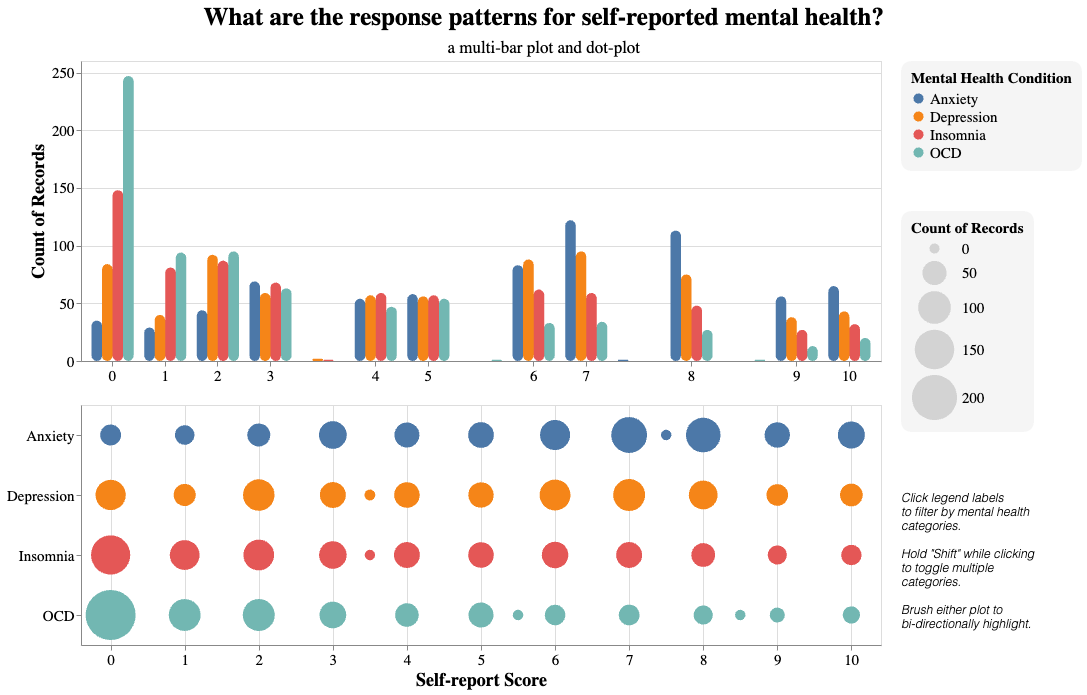

In [8]:
### === Interactions === ###
brush = alt.selection_interval()
selection = alt.selection_point(fields=['Mental Health Condition'], bind='legend')


### === Multi-bar Plot === ###
multibar = alt.Chart(mxmh_scores).add_params(
    brush, selection
).mark_bar(cornerRadius=7).encode(
    x=alt.X('Self-report Score:O', title=None).axis(labelAngle=0, tickMinStep=0.5, values=list(range(0, 11, 1))),
    xOffset="Mental Health Condition:N",
    y='count():Q',
    opacity = alt.condition(selection, alt.value(1), alt.value(0)), 
    color=alt.when(brush).then(alt.Color("Mental Health Condition:N",
                                         legend=alt.Legend(orient='none',
                                                           legendX=820,
                                                           legendY=0))
                              ).otherwise(alt.value("lightgray")),
    tooltip=["Mental Health Condition", 'Self-report Score:O', "count()"]
).properties(width=800, height=300)

### === DOT-PLOT === ###
dotplot = alt.Chart(mxmh_scores).add_params(
    brush, selection
).mark_circle(opacity=0.8).encode(
    x=alt.X('Self-report Score', title="Self-report Score", scale=alt.Scale(domain=[-0.4, 10.4])).axis(tickMinStep=0.5, values=list(range(0, 11, 1))),
    y=alt.Y('Mental Health Condition:N', title=None),
    color=alt.when(brush).then("Mental Health Condition:N").otherwise(alt.value("lightgray")),
    opacity = alt.condition(selection, alt.value(1), alt.value(0)), 
    size = alt.Size("count():Q", scale=alt.Scale(rangeMin=100, rangeMax=2500),
                    legend=alt.Legend(orient='none',
                                      legendX=820,
                                      legendY=150)
                   ),
    tooltip=["Mental Health Condition", "Self-report Score", "count()"]
).properties(width=800, height=240)

### === NOTE === ###
note = alt.Chart({'values': [{}]}).mark_text(
    text=[
        'Click legend labels ', 'to filter by mental health',
        'categories.', '',
        'Hold "Shift" while clicking', 'to toggle multiple', ' categories.', '', 
        'Brush either plot to ', 'bi-directionally highlight.',
    ],
    align='left',
    baseline='bottom',
    fontSize=12,
    y=100,
    x=820,
    fontWeight='lighter',
    fontStyle= 'italic',
)

### === DOT-PLOT & NOTE === ###
dotplot_note = alt.layer(dotplot, note)

### === FINAL CHART #2 ===###
chart2 = alt.vconcat(multibar, dotplot_note
).properties(
    title={
        "text": ["What are the response patterns for self-reported mental health?"],
        "subtitle": ["a multi-bar plot and dot-plot"]
    }
).resolve_scale(
    x='shared'
).configure_legend(
    **legend_configuration
).configure_title(
    **title_configuration
).configure_axis(
    **axis_configuration
).configure_header(
    **header_configuration
)

chart2.show()

- For the visualization below, select the **Mental Health Condition** to look at a condition of interest.
- Use `shift` + click to select multiple categories.

For the visualization below, drag your cursor across the screen to highlight sections of the histogram and dot-chart.

## Question 3: Can we group individuals into clusters based on their music preferences and mental health scores?

In [9]:
import numpy as np


In [10]:
mxmh_raw = pd.read_csv("../data/raw/mxmh_survey_results.csv")

mxmh_jess_q3 = mxmh_raw
mxmh_jess_q3['Music effects'] = mxmh_jess_q3['Music effects'].fillna("No response")

bpmMax = mxmh_raw["BPM"].nlargest(2).index
bpmMin = mxmh_raw["BPM"].nsmallest(5).index
bpmOutliers = bpmMax.union(bpmMin)
mxmh_jess_q3["BPM_cleaned"] = mxmh_jess_q3["BPM"]
# mxmh_jess_q3.loc[bpmMax, "BPM_cleaned"] = 300  # Set top 2 highest values
mxmh_jess_q3.loc[bpmMax, "BPM_cleaned"] = np.nan  # Set top 2 highest values to NAN
# mxmh_jess_q3.loc[bpmMin, "BPM_cleaned"] = 15   # Set bottom 5 lowest values
mxmh_jess_q3.loc[bpmMin, "BPM_cleaned"] = np.nan   # Set bottom 5 lowest values to NAN


mxmh_jess_q3[["BPM_cleaned"]].describe()

# music_effects_map = {"Improve": 1, "No effect": 2, "Worsen": 3, "No response":4}
# mxmh_jess_q3["Music effects"] = mxmh_jess_q3["Music effects"].map(music_effects_map)

music_effects_ordered = ['Improve', 'No effect', 'Worsen', 'No response']
mxmh_jess_q3["Music effects"] = pd.Categorical(mxmh_jess_q3["Music effects"], 
                                              categories=music_effects_ordered, 
                                              ordered=True)

mxmh_jess_q3.reset_index(inplace=True)
mxmh_jess_q3.rename(columns={'index': 'ID'}, inplace=True)
# mxmh_jess_q3

### 3.1

In [11]:
label_data = pd.DataFrame({
    "value": ["Age", "BPM", "BPM_cleaned", "Hours per day"],
    "label": [
        "Age", 
        "BPM (with outliers)", 
        "BPM (no outliers)", 
        "Hours per day"
    ]
})

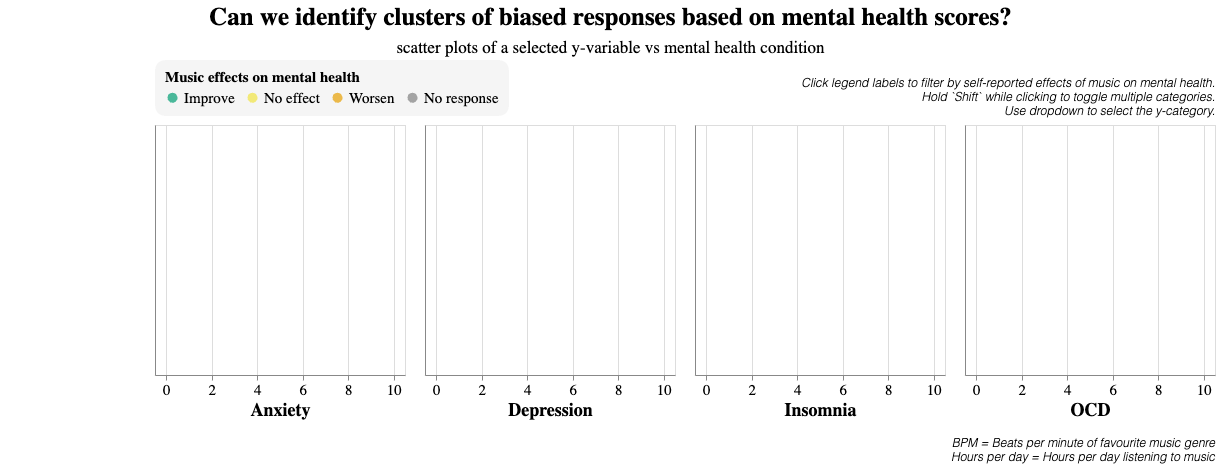

In [18]:
### === WIDGETS & INTERACTIONS === ###

# === Y COLUMN DROP-DOWN ===
dropdown_y = alt.binding_select(
    options=["Age", "BPM", "BPM_cleaned", "Hours per day"], 
    labels=[
        "Age", 
        "BPM (with outliers)", 
        "BPM (no outliers)", 
        "Hours per day"],
    name="Y-axis column: "
)
ycol_param = alt.param(bind=dropdown_y)
# y_axis_selection = alt.binding_select(options=['Age', 'BPM'], name='Y-axis column: ')
# y_axis_variable = alt.param(bind=y_axis_selection, value='Age')

# === INTERACTIONS ===
click = alt.selection_point(empty=False)
hover = alt.selection_point(on="mouseover", empty=False)
brush = alt.selection_interval()

# === filter music effects column ===
selection_me = alt.selection_point(fields=["Music effects"], bind="legend")

### BASE CHART ###
chart3 = (
    alt.Chart(mxmh_jess_q3)
    .mark_circle(opacity=0.7)
    .encode(
        x=alt.X(scale=alt.Scale(domain=[-0.5, 10.5])),
        y=alt.Y("y:Q", title=None),
        color=alt.when(brush)
        .then(alt.Color("Music effects:N", 
                        title="Music effects on mental health", 
                        scale=effect_color_scale, 
                        sort=['Improve', 'No effect', 'Worsen', 'No response']))
        .otherwise(alt.value("lightgray")),
        tooltip=alt.Tooltip(
            ["ID", "Age", "Anxiety", "Depression", "Insomnia", "OCD", "Music effects"]
        ),
        size=alt.when(hover).then(alt.value(800)),
        # opacity=alt.when(selection_me).then(alt.value(0.7)).otherwise(alt.value(0.01)),
    )
    # .properties(width=250, height=250)
    .transform_calculate(
        y=f"datum[{ycol_param.name}]",
    )
    .transform_filter(
        selection_me
    )
    .add_params(hover, brush, ycol_param, selection_me)
)

### === LEFT AXIS CHANGES WITH DROPDOWN === ###
text = (
    alt.Chart(label_data)
    .mark_text(
        align="center",
        angle=270,
        baseline='bottom',  # bottom, middle, top
        fontSize=15,
        fontWeight="bold",
        font=font_choice
    )
    .transform_filter(f"datum.value === {ycol_param.name}")
    .transform_calculate(
        custom_label='datum.label'
    )
    .encode(
        text="custom_label:N"
    )
    .add_params(ycol_param)
    .properties(
        width=130,
        height=250
    )
)

### ANXIETY CHART ###
chart3_anx = chart3.encode(
    x=alt.X("Anxiety:Q", scale=alt.Scale(domain=[-0.5, 10.5])),
    y=alt.Y("y:Q", title=None)
).properties(width=250, height=250)
### DEPRESSION CHART ###
chart3_dep = chart3.encode(
    x=alt.X("Depression:Q", scale=alt.Scale(domain=[-0.5, 10.5])),
    y=alt.Y("y:Q", axis=alt.Axis(labels=False, ticks=False, title=None))
).properties(width=250, height=250)
### INSOMNIA CHART ###
chart3_ins = chart3.encode(
    x=alt.X("Insomnia:Q", scale=alt.Scale(domain=[-0.5, 10.5])),
    y=alt.Y("y:Q", axis=alt.Axis(labels=False, ticks=False, title=None))
).properties(width=250, height=250)
### OCD CHART ###
chart3_ocd = chart3.encode(
    x=alt.X("OCD:Q", scale=alt.Scale(domain=[-0.5, 10.5])),
    y=alt.Y("y:Q", axis=alt.Axis(labels=False, ticks=False, title=None))
).properties(width=250, height=250)


### === NOTE === ###
note = alt.Chart({"values": [{}]}).mark_text(
    text=[
        "Click legend labels to filter by self-reported effects of music on mental health.",
        "Hold `Shift` while clicking to toggle multiple categories.",
        "Use dropdown to select the y-category.",
        "  ",
    ],
    align="right",
    baseline="bottom", # bottom, middle, top
    fontSize=12,
    fontWeight="lighter",
    fontStyle="italic",
    dx=1170,
    dy=-60
).properties(
    width=80,
    height=50
)

### === BPM NOTE === ###
note_bpm = alt.Chart({"values": [{}]}).mark_text(
    text=[
        "BPM = Beats per minute of favourite music genre",
        "Hours per day = Hours per day listening to music",
    ],
    align="right",
    baseline="bottom", # bottom, middle, top
    fontSize=12,
    fontWeight="lighter",
    fontStyle="italic",
    dx=1170,
    dy=250
).properties(
    width=80,
    height=50
)

### FINAL VIZ ###
# chart3_all =  

chart3_final = (
    alt.vconcat(
        alt.hconcat(text, chart3_anx, chart3_dep, chart3_ins, chart3_ocd).properties(
            bounds="flush"
        ),
        note,
        note_bpm,
    )
    .properties(bounds="flush")
    # .resolve_scale(x="shared", y="shared")
    .configure_legend(
        direction="horizontal",
        orient="none",
        legendX=150,
        legendY=-65,
        **legend_configuration,
    )
    .configure_title(**title_configuration)
    .configure_axis(**axis_configuration)
    .configure_header(**header_configuration)
).properties(
    title={
        "text": ["Can we identify clusters of biased responses based on mental health scores?"],
        "subtitle": [
            "scatter plots of a selected y-variable vs mental health condition"
        ],
    },
    spacing=0,
)
chart3_final

# Dashboard

In [19]:
final_chart1.save('jessica M4/jess_chart1.html')
chart2.save('jessica M4/jess_chart2.html')
chart3_final.save('jessica M4/jess_chart3.html')

In [14]:
# pip install streamlit

In [15]:
# import streamlit as st
# import altair as alt
# import pandas as pd

# # Load or generate your charts
# from final_chart1 import final_chart1
# from chart2 import chart2
# from chart3_final import chart3_final

# st.title("🎵 Music & Mental Health Dashboard")

# st.altair_chart(final_chart1, use_container_width=True)
# st.altair_chart(chart2, use_container_width=True)
# st.altair_chart(chart3_final, use_container_width=True)
